# Exploratory Data Analysis of the 102 Flower dataset

This notebook aims to explore the [Oxford's 102 Category Flower Dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/)

The dataset will be inspected in the following terms:
- Visually
- By aspect ratio of the images
- By classes

This is done to:
- Gain insights into the dataset's characteristics, which are essential for selecting appropriate preprocessing techniques.
- Identify class imbalances, which could produce a model to be biased towards dominant classes.
- Understand what data augmentation techniques could be applied in this dataset.
- Select a validation or cross-validation strategy.

In [2]:
# To mount Google Drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pandas opencv-python scikit-learn mat4py matplotlib seaborn tqdm imutils

In [4]:
# Standard Library imports
from pathlib import Path
import random
import os
import math

# External imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from mat4py import loadmat
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm
import imutils

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_colwidth", None)


# Create a folder and parants in the root directory
!mkdir -p "/content/drive/My Drive/DATASETS/102flowers"

# Change into project directory
%cd "/content/drive/My Drive/DATASETS/102flowers"

# Download data if it doesn't already exist
!wget https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz -nc --output-document 102flowers.tgz
!wget https://thor.robots.ox.ac.uk/datasets/flowers-102/imagelabels.mat -nc --output-document imagelabels.mat

# Extract flowers data if they don't exist already
!tar --skip-old-files -xzf 102flowers.tgz

/content/drive/My Drive/DATASETS/102flowers
File ‘102flowers.tgz’ already there; not retrieving.
File ‘imagelabels.mat’ already there; not retrieving.


In [5]:
BASE_PATH = Path("/content/drive/My Drive/DATASETS/102flowers")

IMAGES_PATH = str(BASE_PATH / Path("jpg"))
IMAGE_LABELS_PATH = str(BASE_PATH / Path("imagelabels.mat"))

In [6]:
def list_files(dirpath):
    base_directory = Path(dirpath)
    for child in base_directory.rglob('*.jpg'):
        if child.is_file():
            yield str(child.absolute())

In [7]:
def simple_show(im_path):
    image = cv2.imread(im_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplots(1, 1)
    plt.xticks([]); plt.yticks([])
    plt.imshow(image)


def aspect_aware_resize(image, width, height, inter=cv2.INTER_AREA):
    """
    Modified from [2]
    """
    (h, w) = image.shape[:2]
    dW = 0
    dH = 0


    if w < h:
        image = imutils.resize(image, width=width, inter=inter)
        dH = int((image.shape[0] - height) / 2.0)

    else:
        image = imutils.resize(image, height=height, inter=inter)
        dW = int((image.shape[1] - width) / 2.0)

    (h, w) = image.shape[:2]
    image = image[dH:h - dH, dW:w - dW]

    return cv2.resize(image, (width, height), interpolation=inter)


def plot_in_grid(
    im_paths,
    grid_size,
    target_im_size=None,
    keep_ar=None,
    shuffle=True,
    figwidth=16,
    figheight=8,
    show_im_name=True,
    ):
    """
    Plot images in a grid, with the possibility of resizing them to have an
    aspect ratio of 1.

    im_paths: list of images paths
    grid_size: tuple of ints, (rows, cols)
    target_im_size: int, target width or height of the image
    keep_ar: Wheter to keep the original aspect ratio or not when resizing them
    shuffle: Whether to sample random images or just use them in the given order
    figwidth: in inches, part of the matplotlib figure size
    figheight: in inches, part of the matplotlib figure size
    show_im_name: Whether to show or not the image index on top of each figure
    """

    (rows, cols) = grid_size
    n_images = min(rows * cols, len(im_paths))

    if shuffle:
        im_paths = random.sample(im_paths, n_images)
    else:
        im_paths = im_paths[:n_images]

    fig, axes = plt.subplots(rows, cols, figsize=(figwidth,figheight))
    for i,im_path in tqdm(enumerate(im_paths)):

        image = cv2.imread(im_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax = plt.subplot(rows, cols, i+1)
        plt.xticks([]); plt.yticks([])
        plt.axis('equal')

        if target_im_size:
          if keep_ar:
              image = aspect_aware_resize(image, target_im_size, target_im_size)
          else:
              image = cv2.resize(image, (target_im_size, target_im_size), interpolation=cv2.INTER_AREA)

        plt.imshow(image)

        if show_im_name:
          im_index = int(im_path[-9:-4]) - 1
          plt.title(f"Image index: {im_index}")

    return fig, axes

In [8]:
images_paths = list(list_files(IMAGES_PATH))
images_paths.sort()

image_labels = loadmat(IMAGE_LABELS_PATH)
image_labels = [str(x) for x in image_labels['labels']]

In [9]:
df = pd.DataFrame({
    "img_path": images_paths,
    "label": image_labels,
}, index=pd.RangeIndex(start=1, stop=len(images_paths)+1))

25it [00:08,  3.04it/s]


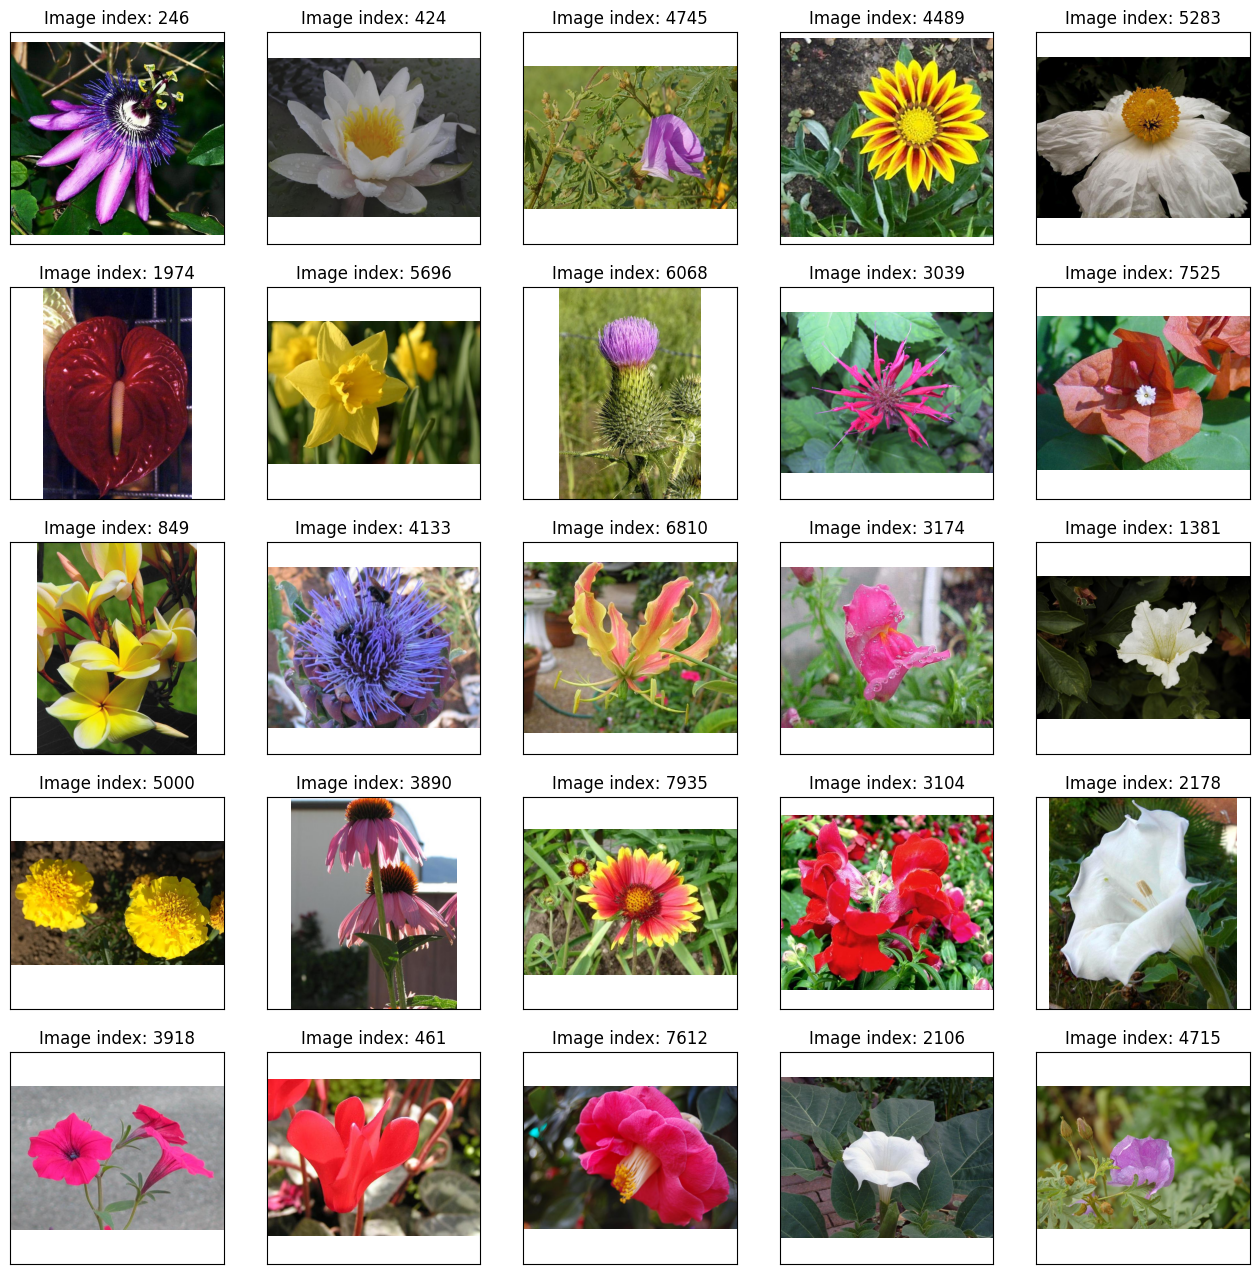

In [10]:
# Explore the dataset by drawing the flowers in a grid
# Repeat and explore, looking for any obvious issue

im_paths = df["img_path"].to_list()
plot_in_grid(im_paths, grid_size=(5, 5), show_im_name=True, figwidth=16, figheight=16)
plt.show()

Visual inspection of the flowers reveals that some photos have a blurred background while others do not. This difference means that not only the flower itself but also the background, such as one with leaves, could serve as a source of detected features. In cases where different flowers share the same background, this could potentially lead to confusion for the model.

The following images show examples where the background could be a source of confussion.

The following image shows a flower and a leaf, which could be completely unrelated to the flower:

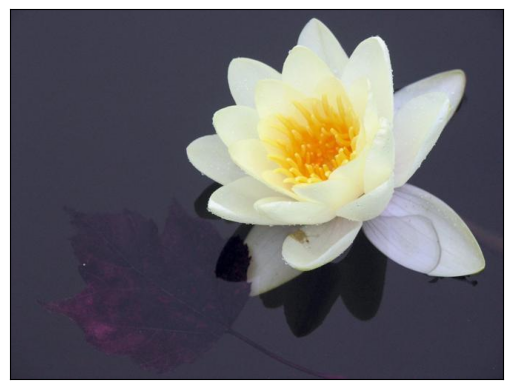

In [11]:
simple_show(df.iloc[277]["img_path"])

# Aspect ratios

Let's explore the aspect ratios (AR) of the images to get an idea of how they appear and whether there are any considerations to keep in mind when resizing or cropping the images. The ResNet input image size is 224x224, which corresponds to an aspect ratio of 1.

If the images were resized without any awareness of their aspect ratios, they could end up looking very distorted, depending on their original aspect ratio.

Let's:

- Explore the distribution of ARs.
- Show what images with the most common ARs look like.
- Show how images with extreme ARs would appear if resized to the dimensions of 224x224 (AR of 1) by simply stretching or shrinking the width or height.

In [12]:
widths = []
heights = []
for img_path in tqdm(df.img_path, total=df.shape[0]):
    img = cv2.imread(img_path)
    (h, w) = img.shape[:2]
    heights.append(h)
    widths.append(w)

df["width"] = widths
df["height"] = heights
df["aspect_ratio"] = df["width"] / df["height"]

100%|██████████| 8189/8189 [03:32<00:00, 38.45it/s] 


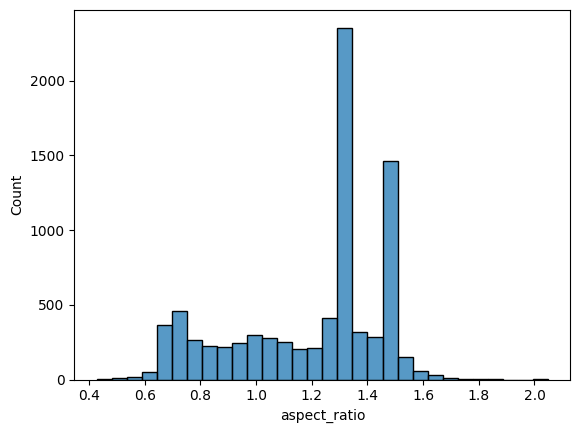

In [13]:
ax = sns.histplot(data=df, x="aspect_ratio", bins=30)

In [14]:
in_aspect_ratio_range = df.loc[(df.aspect_ratio <= 1.2) & (df.aspect_ratio >= 0.8), :].shape[0]
print(f"There are {in_aspect_ratio_range} images inside the [0.8 - 1.2] aspect ratio range, that's {in_aspect_ratio_range/df.shape[0]:.1%} of the dataset.")

There are 1845 images inside the [0.8 - 1.2] aspect ratio range, that's 22.5% of the dataset.


The importance of aspect ratio in a Computer Vision problem depends on the specific domain, and it is not known whether it will have an impact in this case. Could a flower in this dataset be misclassified as another due to a distorted aspect ratio?

Let's explore how images with the most common aspect ratio look:

9it [00:00, 75.20it/s]


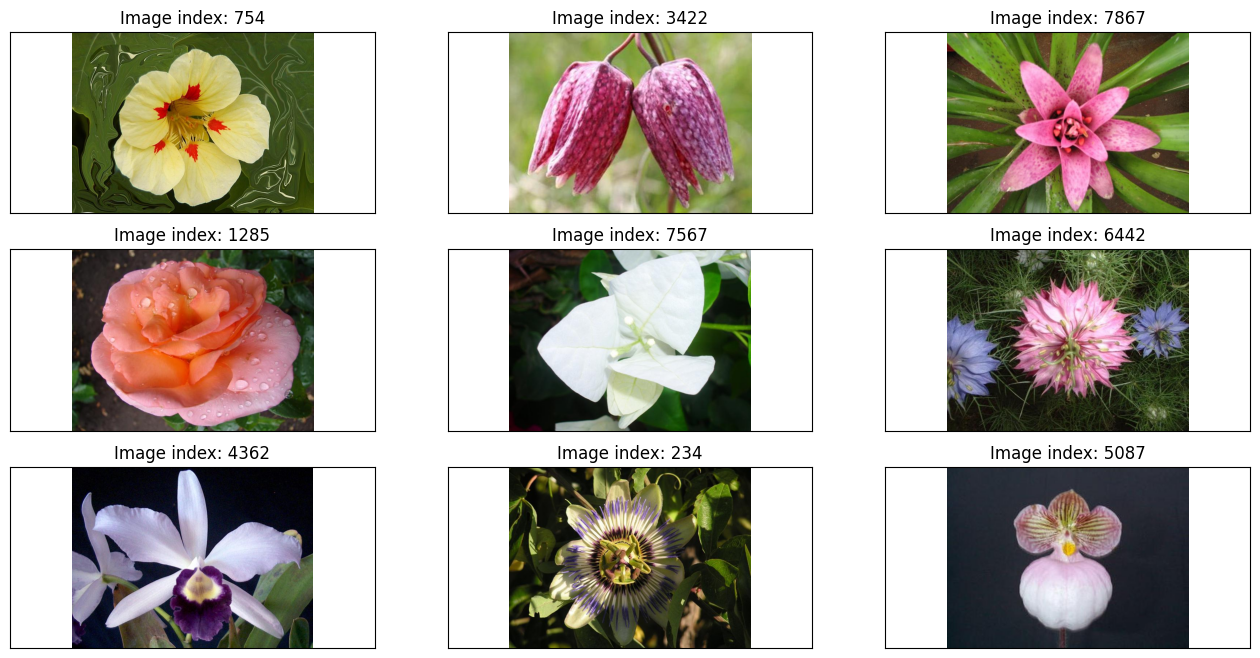

In [15]:
im_paths = df.loc[(df.aspect_ratio >= 1.25) & (df.aspect_ratio <= 1.35), "img_path"].to_list()
plot_in_grid(im_paths, grid_size=(3, 3))
plt.show()

Let's draw the images with the smallest aspect ratio to see how do they look after changing their aspect ratio to be 1.

5it [00:00, 44.26it/s]


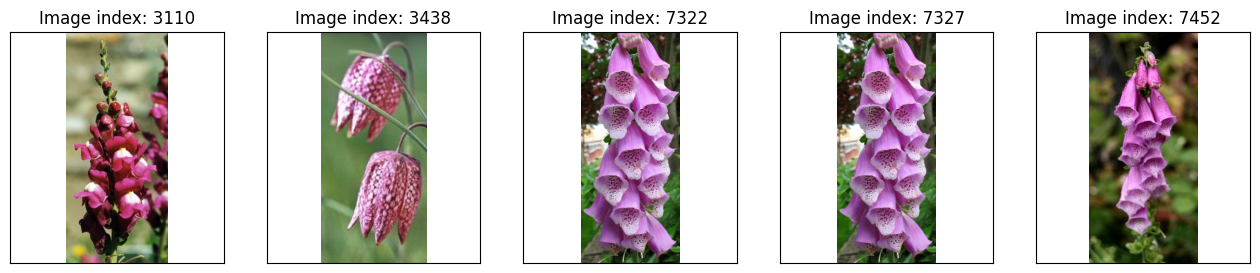

5it [00:00, 46.51it/s]


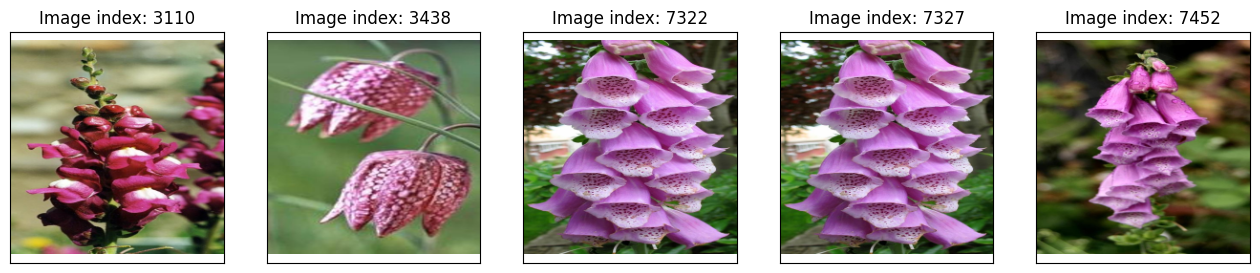

In [16]:
im_paths = df.loc[(df.aspect_ratio <= 0.5), "img_path"].to_list()
figwidth, figheight = 16, 3

# First row, non-resized images with their original aspect ratio
plot_in_grid(im_paths, grid_size=(1,5), shuffle=False, figwidth=figwidth, figheight=figheight)
plt.show()

# Second row, images with a modified aspect ratio of 1
plot_in_grid(im_paths, grid_size=(1,5), target_im_size=224, keep_ar=False, shuffle=False, figwidth=figwidth, figheight=figheight)
plt.show()

Let's draw the images with the highest aspect ratio to see how do they look after changing their AR to be 1.

5it [00:00, 73.08it/s]


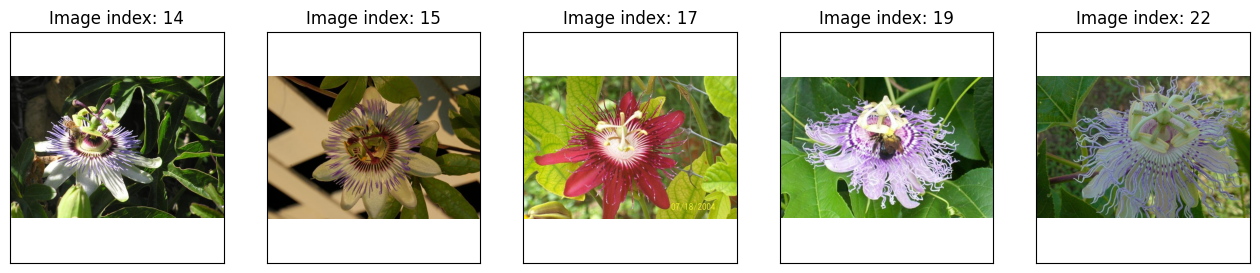

5it [00:00, 64.58it/s]


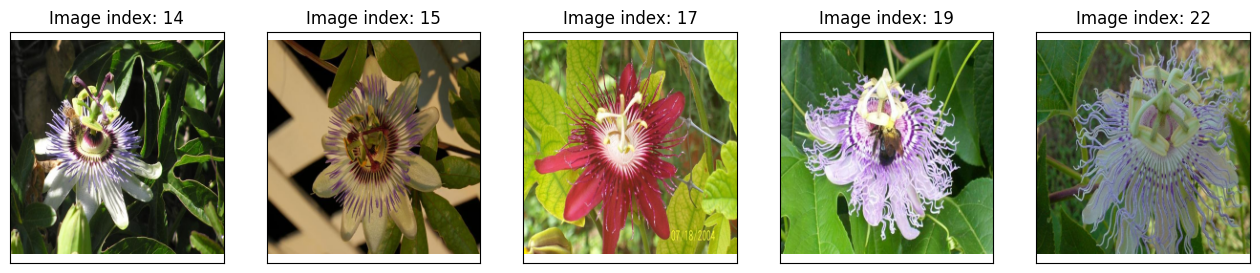

In [17]:
im_paths = df.loc[(df.aspect_ratio >= 1.5), "img_path"].to_list()

# First row, non-resized images with their original aspect ratio
plot_in_grid(im_paths, grid_size=(1,5), shuffle=False, figwidth=figwidth, figheight=figheight)
plt.show()

# Second row, images with a modified aspect ratio of 1
plot_in_grid(im_paths, grid_size=(1,5), target_im_size=224, keep_ar=False, shuffle=False, figwidth=figwidth, figheight=figheight)
plt.show()

The change of aspect ratio due to resizing doesn't seem to visually distort the images to the extent that they become unrecognizable or difficult to distinguish.

Let's see how they would appear when resized to the desired size while maintaining their aspect ratio. There are at least two methods to resize an image while preserving its aspect ratio:

- Resize it and pad it.
- Resize it and crop it.

The method that will be used here is the one of resizing it and cropping while preserving the center of the image.

5it [00:00, 78.92it/s]


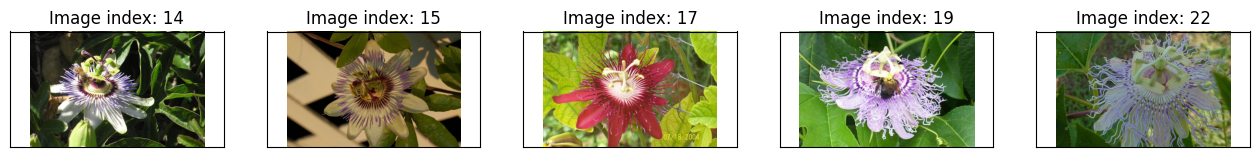

5it [00:00, 61.74it/s]


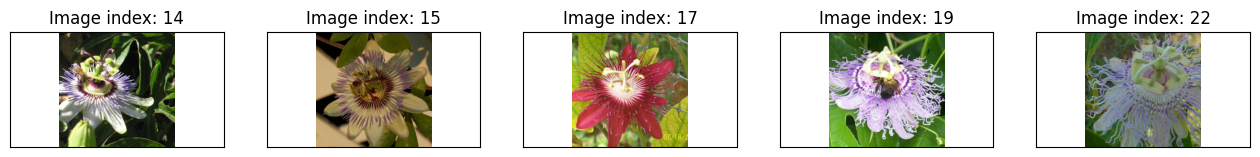

In [18]:
im_paths = df.loc[(df.aspect_ratio >= 1.5), "img_path"].to_list()
figwidth, figheight = 16, 1.5

# First row, non-resized images with their original aspect ratio
plot_in_grid(im_paths, grid_size=(1,5), shuffle=False, figwidth=figwidth, figheight=figheight)
plt.show()

# Second row, images with a modified aspect ratio of 1
plot_in_grid(im_paths, grid_size=(1,5), target_im_size=224, keep_ar=True, shuffle=False, figwidth=figwidth, figheight=figheight)
plt.show()

5it [00:00, 59.77it/s]


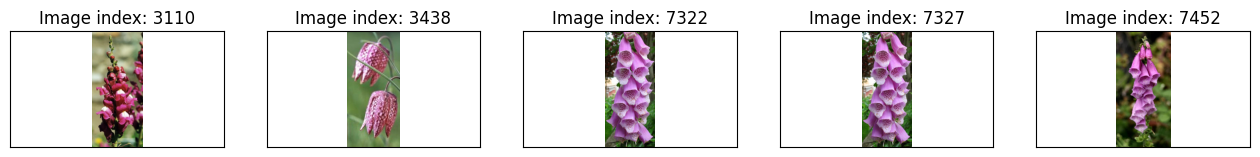

5it [00:00, 47.59it/s]


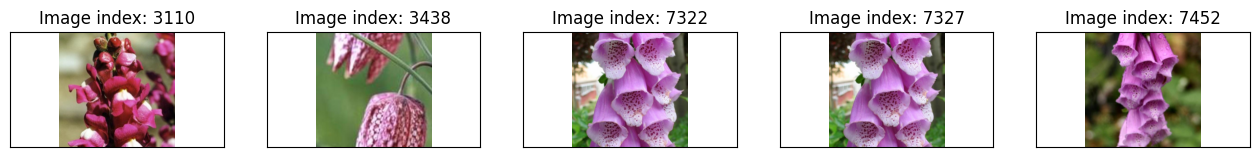

In [19]:
im_paths = df.loc[(df.aspect_ratio <= 0.5), "img_path"].to_list()
figwidth, figheight = 16, 1.5

# First row, non-resized images with their original aspect ratio
plot_in_grid(im_paths, grid_size=(1,5), shuffle=False, figwidth=figwidth, figheight=figheight)
plt.show()

# Second row, images with a modified aspect ratio of 1
plot_in_grid(im_paths, grid_size=(1,5), target_im_size=224, keep_ar=True, shuffle=False, figwidth=figwidth, figheight=figheight)
plt.show()

It can be observed that in image 3438, where there are two flowers, neither of them is in the center, resulting in a cropped image that shows two half flowers. This could potentially be a problem.

# Exploring of classes

Let's explore how do the images look like in some random classes:

5it [00:00, 82.62it/s]


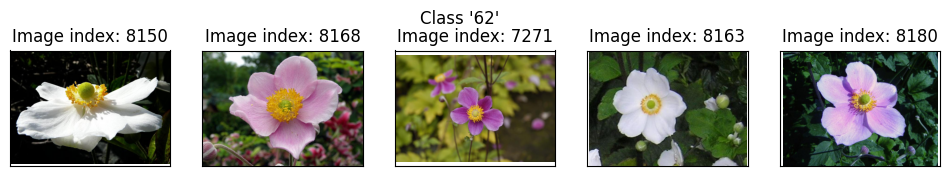

5it [00:00, 47.68it/s]


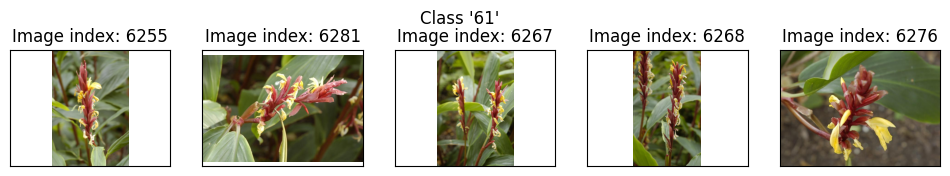

5it [00:00, 64.32it/s]


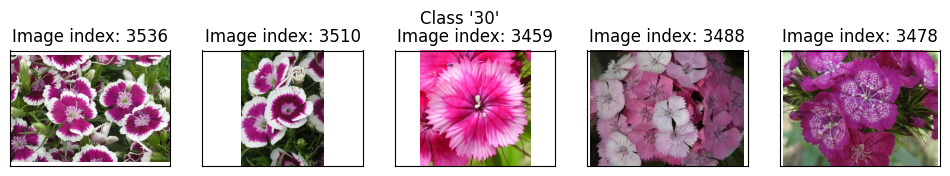

5it [00:00, 53.30it/s]


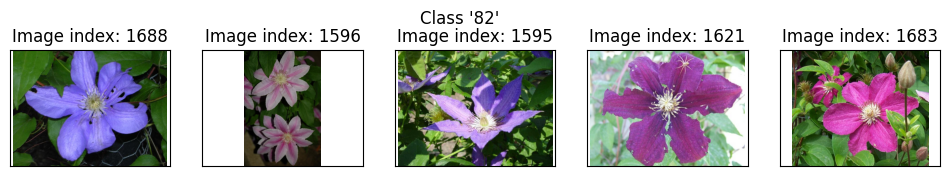

5it [00:00, 53.98it/s]


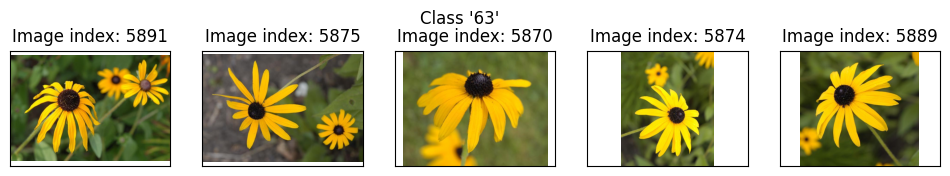

5it [00:00, 53.20it/s]


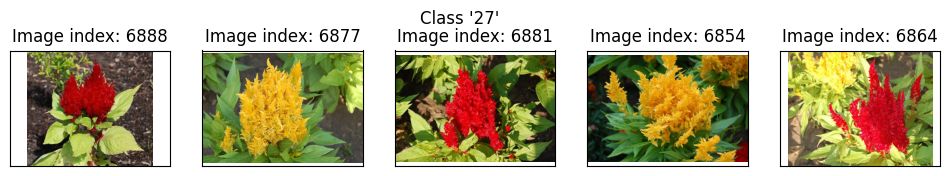

5it [00:00, 79.71it/s]


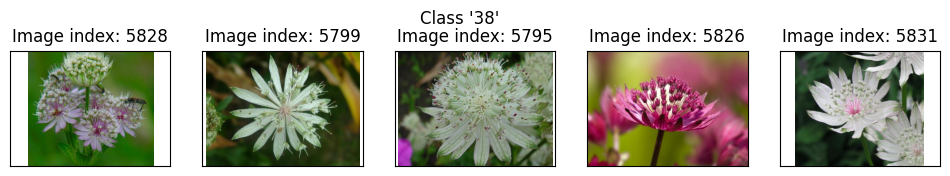

5it [00:00, 84.83it/s]


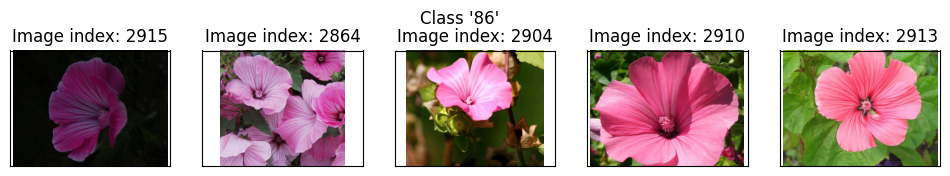

5it [00:00, 77.09it/s]


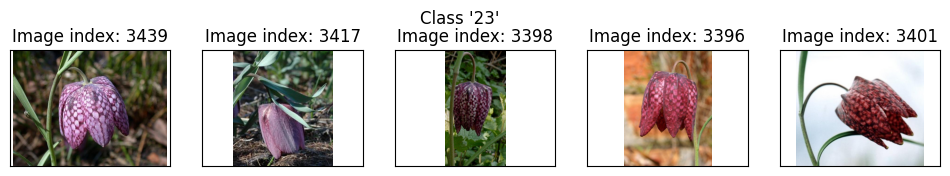

5it [00:00, 78.16it/s]


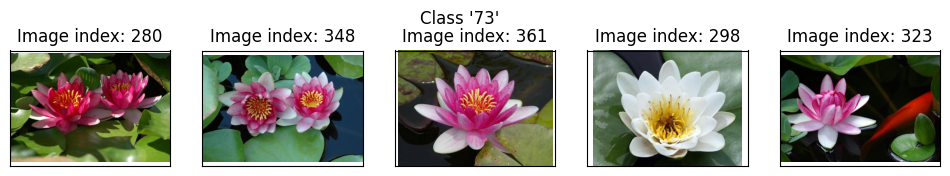

In [20]:
figwidth, figheight = 12, 1.5
random_labels = random.sample(df['label'].unique().tolist(), 10)
for label in random_labels:
    random_im_paths = random.sample(df.loc[df.label == label, 'img_path'].to_list(), 10)
    fig, axes = plot_in_grid(random_im_paths, grid_size=(1,5), figwidth=figwidth, figheight=figheight)
    fig.suptitle(f"Class '{label}'", y=1.15)
    plt.show()

It can be observed that flowers from the same class exhibit varying colors, possibly due to differences in their life stage or slight variants in the flower type.

The following histogram shows the distribution of the number of images per flower class. A red line represents the median number of images per class.

Number of images per class, median: 66.0, mean: 80.3


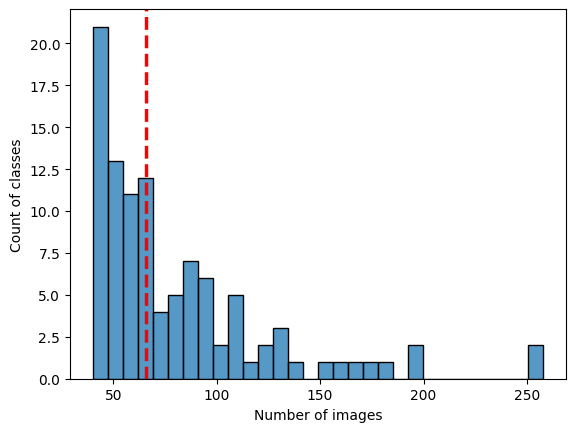

In [21]:
median = df['label'].value_counts().median()
mean = df['label'].value_counts().mean()
ax = sns.histplot(df['label'].value_counts().to_list(), bins=30)
line = ax.axvline(x=median, color='red', ls='--', lw=2.5)
ax.set_ylabel('Count of classes')
ax.set_xlabel('Number of images')
print(f"Number of images per class, median: {median:.1f}, mean: {mean:.1f}")

The mean number of images per class is 80. For a simple data split of 60% for training, 20% for validation, and 20% for testing, this would leave less than 48 images for training and 16 for validation and testing.

According to [2, Ch 8.2], when dealing with a small dataset, fine-tuning isn't recommended as it can lead to overfitting. Typically, datasets with fewer than 1000 images are considered 'small.'

There are two possible approaches to take when the available data is small, depending on how similar the original dataset on which the original Deep Net was trained is to the dataset at hand. If the dataset is similar, extract features using deep-level layers and train a classifier with them. If the dataset is different, extract features using lower-level layers and train a classifier with them. The difference between lower-level and deeper-level layers is that deeper-level layers are more specific and representative of the original dataset on which they were trained.

The Imagenet dataset consists of 1000 classes, but only two of them correspond to flowers, namely 'daisy' and 'yellow lady's slipper.' This could be considered a different dataset, and in such cases, it is recommended to train a classifier using the lower-level convolutional layers of the pre-trained model.

Other suggestions, as mentioned in [4], propose that when performing Transfer Learning by fine-tuning networks, overfitting can be mitigated by retraining the model or a part of it using a low learning rate.

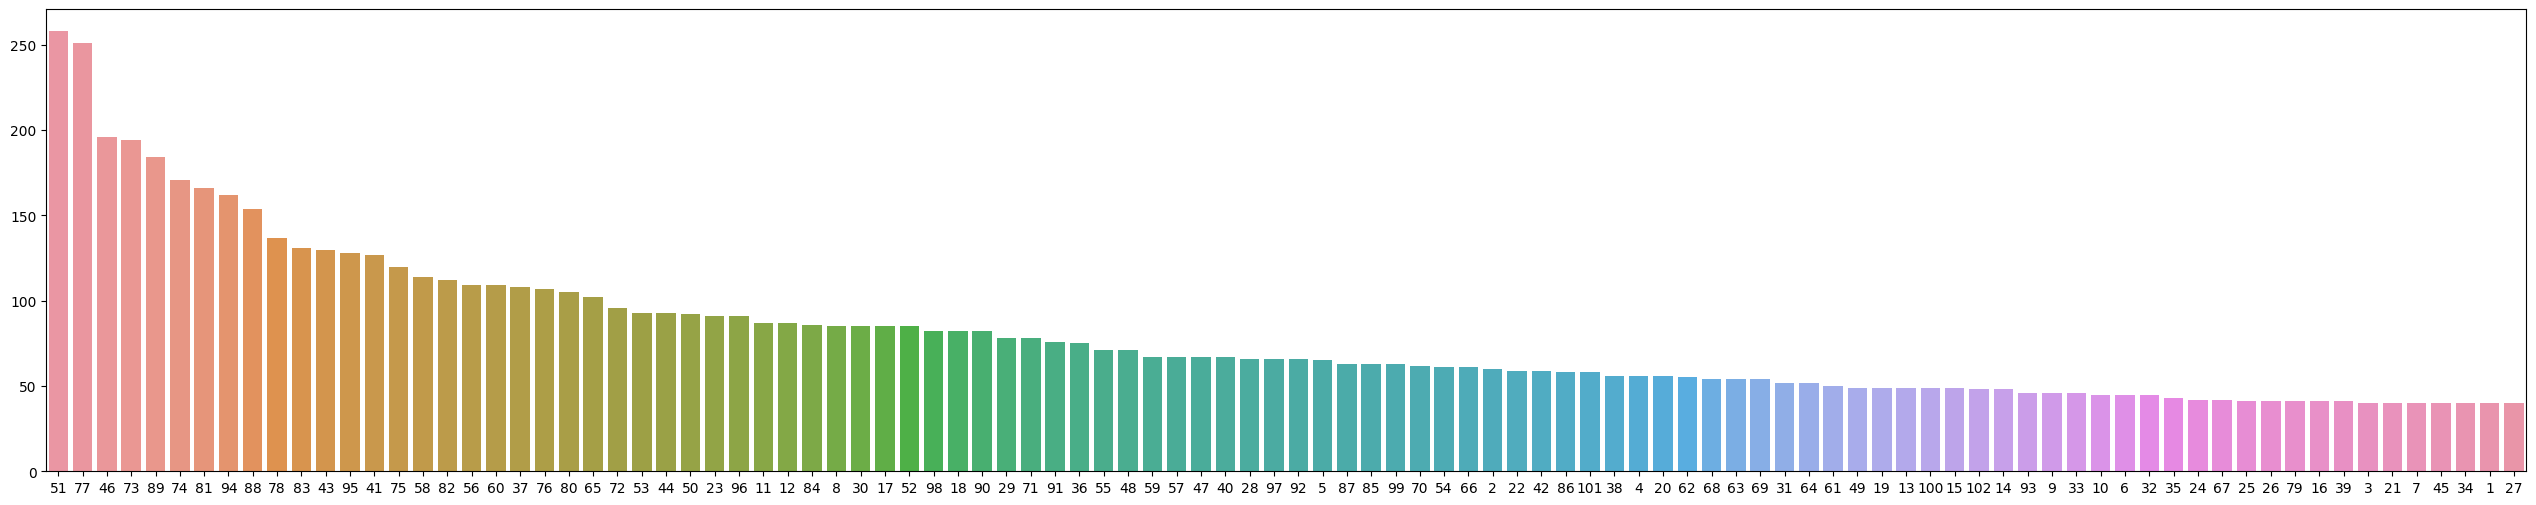

In [22]:
counts = df.label.value_counts()
figwidth, figheight = 32, 6
fig, axes = plt.subplots(1, 1, figsize=(figwidth, figheight))
ax = sns.barplot(x=counts.index, y=counts.values, orient="v", ax=axes)

The above graph shows the number of images found in each class.

# Conclusions

- The visual examination reveals potential challenges in distinguishing flowers from backgrounds.
- Flowers from the same class exhibit varying colors, possibly due to differences in life stage.
- Resizing images while maintaining their original aspect ratios and center-cropping them can effectively prevent distortion, but it may result in images where, if the flower is not positioned in the center, parts of the flower may be cropped out, causing them not to be fully displayed in the resized images.
- The small dataset, with a mean of 80 images per class and less than 1000 images per class, suggests that fine-tuning is less recommended due to the risk of overfitting. In such cases, it's advisable to use feature extraction from pre-trained models, with a preference for lower-level convolutional layers when the dataset significantly differs from the original.



## References
- [1] Deep Learning for Computer Vision with Python - Starter bundle
- [2] Deep Learning for Computer Vision with Python - Practitioner Bundle
- [3] https://paperswithcode.com/sota/image-classification-on-flowers-102
- [4] https://neptune.ai/blog/transfer-learning-guide-examples-for-images-and-text-in-keras
- [5] https://paperswithcode.com/paper/resnet-strikes-back-an-improved-training